<a href="https://colab.research.google.com/github/Ibraam-Nashaat/Stroke-Prediction/blob/main/Stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import tree 
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
df=pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

In [3]:
def model_fit(x_train,y_train,x_test,y_test,dt_best_params_,rf_best_params_,svm_best_params_):
  models={'Logistic regression: ':LogisticRegression(max_iter=1000,random_state=39),
          'Decision Tree: ':tree.DecisionTreeClassifier(**dt_best_params_),
          'KNN: ':KNeighborsClassifier(n_neighbors=1),
          'SVM: ':SVC(**svm_best_params_),
          'Random Forest: ': RandomForestClassifier(**rf_best_params_)}

  model_report={}
  for name,model in models.items():
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    model_report[name]= classification_report(y_test, y_pred)
  return model_report

In [4]:
def models_best_parameters(x_train,y_train):
  
  rf_grid_search={
      'criterion':['gini', 'entropy'],
      'max_depth':[100,200,None],
      'min_samples_split':[2,3,4],
      'min_samples_leaf':[1,2,3],
      'max_features':['sqrt', 'log2', None]}
      
  svm_grid_search={
      'kernel':["linear", "poly", "rbf", "sigmoid"],
      'degree':[3,4],}

  dt_grid_search={
      'criterion':['gini', 'entropy'],
      'max_depth':[100,200,None],
      'min_samples_split':[2,3,4],
      'min_samples_leaf':[1,2,3],
      'max_features':['sqrt', 'log2', None],
      'splitter': ['best', 'random']}

  def grid_search_fun(grid,model,x_train,y_train):
        best_model_search=GridSearchCV(estimator=model,param_grid=grid,cv=4,verbose=-1,n_jobs=-1)
        best_model_search.fit(x_train,y_train)
        return best_model_search.best_params_
        
  rf_best_params=grid_search_fun(rf_grid_search,RandomForestClassifier(),x_train,y_train)
  svm_best_params=grid_search_fun(svm_grid_search,SVC(),x_train,y_train)
  dt_best_params=grid_search_fun(dt_grid_search,tree.DecisionTreeClassifier(),x_train,y_train)

  
  return rf_best_params, svm_best_params,dt_best_params

## Data Exploration

In [5]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [6]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

- We notice that there are null values in ***bmi*** column which we need to replace.

In [7]:
df.drop('id',axis=1,inplace=True) #We dropped the id column as it has no meaning to the model
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [8]:
df.describe() 

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [9]:
# We must check that there are no unexpected unique values in each column
for col in df.columns:
  if df[col].dtype != 'float64':
    print(f"{col} has unique values:{df[col].unique()}")

gender has unique values:['Male' 'Female' 'Other']
hypertension has unique values:[0 1]
heart_disease has unique values:[1 0]
ever_married has unique values:['Yes' 'No']
work_type has unique values:['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type has unique values:['Urban' 'Rural']
smoking_status has unique values:['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke has unique values:[1 0]


- All unique values are as expected.

### Filling Null Data

In [10]:
#We will fill the null values of bmi column with the mean of this column
df['bmi'].fillna(value=df['bmi'].mean(),inplace=True)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


In [11]:
df.isnull().sum().sum()

0

## Data Visualization

([<matplotlib.patches.Wedge at 0x7ff8530e6a90>,
 [Text(0.3354698287660306, -2.1742722906728336, 'Not Stroke'),
  Text(-0.33546985421228903, 2.174272286746714, 'Stroke')],
 [Text(0.2439780572843859, -1.5812889386711517, '95.1%'),
  Text(-0.24397807579075567, 1.5812889358157922, '4.9%')])

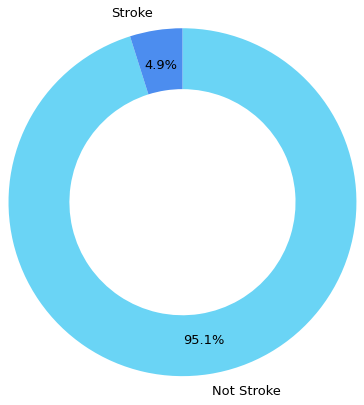

In [12]:
stroke_count=df['stroke'].value_counts()
plt.pie(stroke_count,labels=['Not Stroke','Stroke'],startangle=90,counterclock=False,wedgeprops = {'width' : 0.7},radius=2,autopct='%.1f%%',
        pctdistance=0.8,colors=['#6AD4F5','#4C8DEF'],textprops={'fontsize': 13})

- From this pie chart, we can notice that the number of patients with stroke to that with no stroke is unbalanced which would baise the model. We need to balance them.

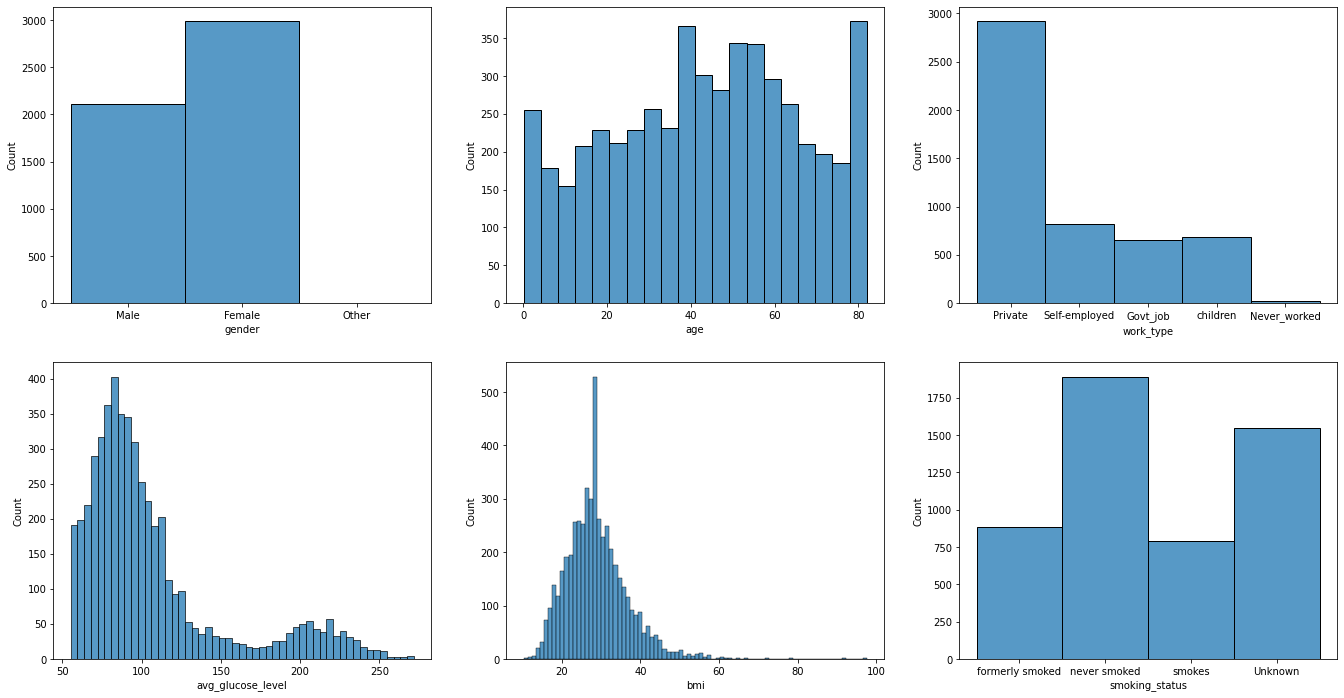

In [13]:
fig, axs = plt.subplots(2, 3,figsize=(23,12))
sns.histplot(df['gender'],kde=False,ax=axs[0,0])
sns.histplot(df['age'],kde=False,ax=axs[0,1])
sns.histplot(df['work_type'],kde=False,ax=axs[0,2])
sns.histplot(df['avg_glucose_level'],kde=False,ax=axs[1,0])
sns.histplot(df['bmi'],kde=False,ax=axs[1,1])
sns.histplot(df['smoking_status'],kde=False,ax=axs[1,2])

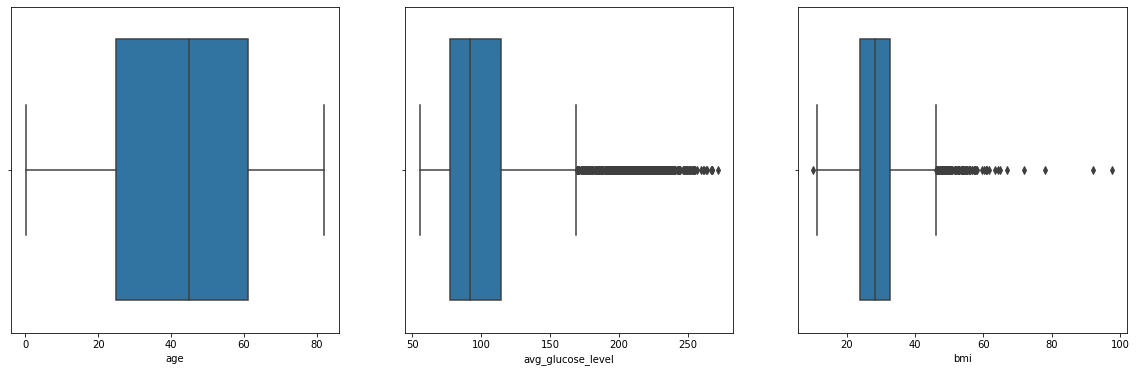

In [14]:
fig, axs = plt.subplots(1,3 ,figsize=(20,6))
sns.boxplot(x=df["age"],ax=axs[0])
sns.boxplot(x=df["avg_glucose_level"],ax=axs[1])
sns.boxplot(x=df["bmi"],ax=axs[2])

## Label Encoding

- We need to convert the categorical strings into numbers so that we can feed them into the model.

In [15]:
categorical_col=['gender','ever_married','work_type','Residence_type','smoking_status']
le = LabelEncoder()
for col in categorical_col:
  df[col] = le.fit_transform(df[col])

for col in df.columns:
  if df[col].dtype != 'float64':
    print(f"{col} has unique values:{df[col].unique()}")

gender has unique values:[1 0 2]
hypertension has unique values:[0 1]
heart_disease has unique values:[1 0]
ever_married has unique values:[1 0]
work_type has unique values:[2 3 0 4 1]
Residence_type has unique values:[1 0]
smoking_status has unique values:[1 2 3 0]
stroke has unique values:[1 0]


## Model Fitting Before Balancing

In [16]:
# Dividing the data into input and output
x=df.drop('stroke',axis=1)
y=df['stroke']
x.shape,y.shape

((5110, 10), (5110,))

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42) # Splitting the data into train data and test data
rf_best_params, svm_best_params,dt_best_params=models_best_parameters(x_train,y_train)
model_report=model_fit(x_train,y_train,x_test,y_test,dt_best_params,rf_best_params,svm_best_params)
for name,model in model_report.items():
  print(f'Model name:{name}\n{model}\n')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Model name:Logistic regression: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.00      0.00      0.00        89

    accuracy                           0.94      1533
   macro avg       0.47      0.50      0.49      1533
weighted avg       0.89      0.94      0.91      1533


Model name:Decision Tree: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1444
           1       0.17      0.01      0.02        89

    accuracy                           0.94      1533
   macro avg       0.55      0.50      0.49      1533
weighted avg       0.90      0.94      0.91      1533


Model name:KNN: 
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1444
           1       0.17      0.15      0.16        89

    accuracy                           0.91      1533
   macro avg       0.56      0.55      0.55      

- We can notice that F1 score for 1 equals zero which means that the model almost doesn't predict 1 so we need to balance the data.

## Model Balancing then Fitting

([<matplotlib.patches.Wedge at 0x7ff8527eb0d0>,
 [Text(2.2, 0.0, 'Not Stroke'), Text(-2.2, -2.6942229581241775e-16, 'Stroke')],
 [Text(1.6, 0.0, '50.0%'), Text(-1.6, -1.9594348786357652e-16, '50.0%')])

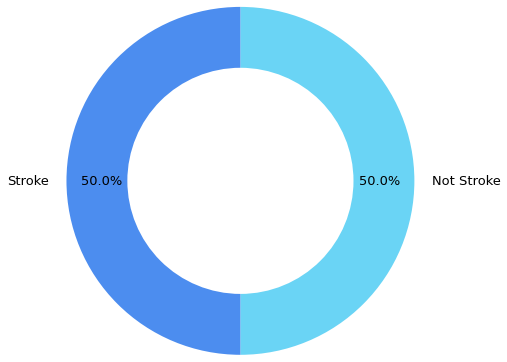

In [18]:
smote=SMOTE(sampling_strategy='minority')
x,y=smote.fit_resample(x,y)
stroke_count=y.value_counts()
plt.pie(stroke_count,labels=['Not Stroke','Stroke'],startangle=90,counterclock=False,wedgeprops = {'width' : 0.7},radius=2,autopct='%.1f%%',
        pctdistance=0.8,colors=['#6AD4F5','#4C8DEF'],textprops={'fontsize': 13})

- We can see that the data is now balanced.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
rf_best_params, svm_best_params,dt_best_params=models_best_parameters(x_train,y_train)
model_report=model_fit(x_train,y_train,x_test,y_test,dt_best_params,rf_best_params,svm_best_params)
for name,model in model_report.items():
  print(f'Model name:{name}\n{model}\n')

Model name:Logistic regression: 
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1457
           1       0.79      0.84      0.81      1460

    accuracy                           0.81      2917
   macro avg       0.81      0.81      0.81      2917
weighted avg       0.81      0.81      0.81      2917


Model name:Decision Tree: 
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1457
           1       0.88      0.92      0.90      1460

    accuracy                           0.90      2917
   macro avg       0.90      0.90      0.90      2917
weighted avg       0.90      0.90      0.90      2917


Model name:KNN: 
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      1457
           1       0.87      0.98      0.92      1460

    accuracy                           0.92      2917
   macro avg       0.92      0.92      0.92      